In [11]:
import pandas as pd

In [13]:
data = pd.read_csv('data/imdb-reviews-pt-br.csv', index_col=0)
display(data)

,text_en,text_pt,sentiment
id,,,
1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...,...
49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos


<AxesSubplot: ylabel='count'>

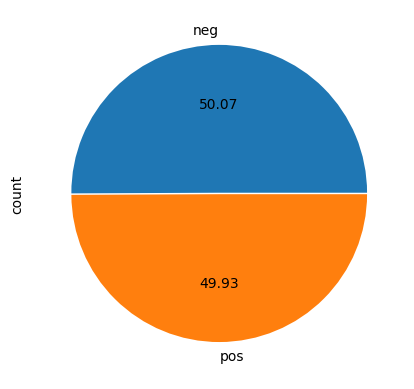

In [3]:
data['sentiment'].value_counts().plot.pie(autopct='%.2f', explode=[0.01, 0])

In [14]:
from sklearn.model_selection import train_test_split

test_dev_size = int(0.05*data.shape[0])
train_dev, test = train_test_split(data, test_size=test_dev_size, random_state=42, stratify=data['sentiment'])
train, dev = train_test_split(train_dev, test_size=test_dev_size, random_state=42, stratify=train_dev['sentiment'])
print('Training samples:', train.shape[0])
print('Dev samples:     ', dev.shape[0])
print('Test samples:    ', test.shape[0])

Training samples: 44515
Dev samples:      2472
Test samples:     2472


In [15]:
from torch.utils.data import Dataset


class ImdbPt(Dataset):
    ''' Loads IMDB-pt dataset. 
    
    It will tokenize our inputs and cut-off sentences that exceed 512 tokens (the pretrained BERT limit)
    '''
    def __init__(self, tokenizer, X, y):
        X = list(X)
        y = list(y)
        tokenized_data = tokenizer(X, truncation=True, max_length=512)
        samples = [
            {
                **{key: tokenized_data[key][i] for key in tokenized_data},
                'labels': y[i]
            }
             
            for i in range(len(X))
        ]
        self.samples = samples
    
    def __getitem__(self, i):
        return self.samples[i]
    
    def __len__(self):
        return len(self.samples)

In [16]:
def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}

In [20]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
train_dataset = ImdbPt(tokenizer, train['text_pt'], (train['sentiment'] == 'pos').astype(int))
dev_dataset   = ImdbPt(tokenizer, dev['text_pt'], (dev['sentiment'] == 'pos').astype(int))
test_dataset  = ImdbPt(tokenizer, test['text_pt'], (test['sentiment'] == 'pos').astype(int))

In [21]:


train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=DataCollatorWithPadding(tokenizer))
dev_loader = DataLoader(dev_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))

In [22]:
import torch 
from transformers import BertForSequenceClassification
from transformers import AdamW

model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased')
model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9997)


for param in model.base_model.parameters():
    param.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\João Vitor\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
import numpy as np
def evaluate(model, dev_loader, device):
    with torch.no_grad():
        model.eval()
        dev_losses = []
        tp, tn, fp, fn = [], [], [], []
        for inputs in dev_loader:
            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            dev_losses.append(loss.cpu().item())

            _, classification = torch.max(scores, 1)
            labels = inputs['labels']
            tp.append(((classification==1) & (labels==1)).sum().cpu().item())
            tn.append(((classification==0) & (labels==0)).sum().cpu().item())
            fp.append(((classification==1) & (labels==0)).sum().cpu().item())
            fn.append(((classification==0) & (labels==1)).sum().cpu().item())

        tp_s, tn_s, fp_s, fn_s = sum(tp), sum(tn), sum(fp), sum(fn)
        print('Dev loss: {:.2f}; Acc: {:.2f}; tp: {}; tn: {}; fp: {}; fn: {}'.format( 
              np.mean(dev_losses), (tp_s+tn_s)/(tp_s+tn_s+fp_s+fn_s), tp_s, tn_s, fp_s, fn_s))

        model.train()

In [11]:
from tqdm import tqdm_notebook
import os
epoch_bar = tqdm_notebook(range(1))
loss_acc = 0
alpha = 0.95
for epoch in epoch_bar:
    batch_bar = tqdm_notebook(enumerate(train_loader), desc=f'Epoch {epoch}', total=len(train_loader))
    for idx, inputs in batch_bar:
        if (epoch * len(train_loader) + idx) == 800:
            for param in model.base_model.parameters():
                param.requires_grad = True

        inputs = send_inputs_to_device(inputs, device)
        optimizer.zero_grad()
        loss, logits = model(**inputs)[:2]
        
        loss.backward()
        optimizer.step()
        if epoch == 0 and idx == 0:
            loss_acc = loss.cpu().item()
        else:
            loss_acc = loss_acc * alpha + (1-alpha) * loss.cpu().item()
        batch_bar.set_postfix(loss=loss_acc)
        if idx%200 == 0:
            del inputs
            del loss
            evaluate(model, dev_loader, device)

        scheduler.step()


        
    os.makedirs('/kaggle/working/checkpoints/epoch'+str(epoch))
    model.save_pretrained('/kaggle/working/checkpoints/epoch'+str(epoch))

C:\Users\João Vitor\AppData\Local\Temp\ipykernel_13944\1419208846.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_bar = tqdm_notebook(range(1))


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\João Vitor\AppData\Local\Temp\ipykernel_13944\1419208846.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  batch_bar = tqdm_notebook(enumerate(train_loader), desc=f'Epoch {epoch}', total=len(train_loader))


Epoch 0:   0%|          | 0/5565 [00:00<?, ?it/s]

Dev loss: 0.70; Acc: 0.49; tp: 1184; tn: 37; fp: 1201; fn: 50
Dev loss: 0.70; Acc: 0.50; tp: 1150; tn: 95; fp: 1143; fn: 84
Dev loss: 0.69; Acc: 0.52; tp: 1102; tn: 181; fp: 1057; fn: 132
Dev loss: 0.69; Acc: 0.54; tp: 1050; tn: 273; fp: 965; fn: 184
Dev loss: 0.69; Acc: 0.54; tp: 1050; tn: 287; fp: 951; fn: 184
Dev loss: 0.43; Acc: 0.85; tp: 976; tn: 1123; fp: 115; fn: 258
Dev loss: 0.32; Acc: 0.88; tp: 984; tn: 1184; fp: 54; fn: 250
Dev loss: 0.26; Acc: 0.90; tp: 1149; tn: 1065; fp: 173; fn: 85
Dev loss: 0.24; Acc: 0.91; tp: 1141; tn: 1103; fp: 135; fn: 93
Dev loss: 0.23; Acc: 0.91; tp: 1128; tn: 1127; fp: 111; fn: 106
Dev loss: 0.25; Acc: 0.90; tp: 1167; tn: 1063; fp: 175; fn: 67
Dev loss: 0.24; Acc: 0.91; tp: 1167; tn: 1072; fp: 166; fn: 67
Dev loss: 0.23; Acc: 0.92; tp: 1104; tn: 1159; fp: 79; fn: 130
Dev loss: 0.22; Acc: 0.92; tp: 1130; tn: 1135; fp: 103; fn: 104
Dev loss: 0.23; Acc: 0.91; tp: 1163; tn: 1093; fp: 145; fn: 71
Dev loss: 0.22; Acc: 0.92; tp: 1136; tn: 1133; fp: 105;

In [69]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer

caminho_modelo = '/kaggle/working/checkpoints/epoch'+str(0)
model = BertForSequenceClassification.from_pretrained(caminho_modelo)

inputs = tokenizer("O palmeiras perdeu a partida para o Boca Juniors e foi classificado para a final da liberdadores", return_tensors="pt")
output = model(**inputs)
scores = output['logits']
prob_pos = F.softmax(scores, dim=1)[:,1]

limiar_positivo = 0.6
limiar_negativo = 0.4

# Categoriza com base nos limiares
categorias = []
for prob in prob_pos:
    if prob_pos[0] >= limiar_positivo:
        categorias.append("positivo")
    elif prob_pos[0] <= limiar_negativo:
        categorias.append("negativo")
    else:
        categorias.append("neutro")

# categorias agora contém as categorias atribuídas com base nos limiares
print(categorias)

print(prob_pos[0])

['positivo']
tensor(0.7094, grad_fn=<SelectBackward0>)


TRATANDO O DATASET COM 3000 TOKENS

In [80]:
import pandas as pd

# Lê o arquivo CSV
df = pd.read_csv('data/am_scrape_final.csv')

# Seleciona apenas os primeiros 1100 registros e a coluna "Review"
new_df = df.head(1100)[["Review"]]

# Exibe o novo DataFrame
display(new_df)


,Review
0,Com a necessidade de comprar um celular custo ...
1,Minha experiência de 10 dias de uso com o Xiao...
2,"Smartphone de qualidade como já esperava, boas..."
3,atendeu mto minhas expectativas. Antes eu usa...
4,"Gostei muito do celular, tem resposta rápida e..."
...,...
1095,A mídia não pôde ser carregada.\n ...
1096,"Em Perfeito estado, simplesmente impecável!"
1097,"Comprei e chegou 6 dias antes do prazo, mesmo ..."
1098,"O áudio é incrível, os discos e o material grá..."


TRATANDO O DATASET PARA 512 TOKENS

In [85]:
pip install nltk

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---------- ----------------------------- 0.4/1.5 MB 12.9 MB/s eta 0:00:01
     ------------------------- -------------- 1.0/1.5 MB 12.3 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 12.0 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 12.0 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 8.0 MB/s eta 0:00:00
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/97.9 kB ? eta -:--:--
   ------------------------------------- -- 92.2/97.9 kB ? eta -:--:--
   ------------------------------------- -- 92.2/97.9 kB ? eta -:--:--
   ---------------------------------------- 97.9/97.9 kB 933.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use 

In [87]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Lê o arquivo CSV
df_512 = pd.read_csv('data/am_scrape_final.csv')

# Seleciona apenas os primeiros 1100 registros e a coluna "Review"

# Função para contar tokens em uma linha
def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Conta tokens e filtra linhas com menos de 513 tokens
new_df_512 = df_512[df_512["Review"].apply(count_tokens) < 513]

new_df_512 = new_df_512.head(1100)[["Review"]]
# Exibe o DataFrame tratado
display(new_df_512)


[nltk_data] Downloading package punkt to C:\Users\João
[nltk_data]     Vitor\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


,Review
0,Com a necessidade de comprar um celular custo ...
1,Minha experiência de 10 dias de uso com o Xiao...
2,"Smartphone de qualidade como já esperava, boas..."
3,atendeu mto minhas expectativas. Antes eu usa...
4,"Gostei muito do celular, tem resposta rápida e..."
...,...
1099,Disco duplo com uma formatação muito caprichad...
1100,Vinil maravilhoso ! Veio em perfeito estado e ...
1101,Esse é embassado
1102,Gostei


Padronização/Limpeza dos dados

In [88]:
import pandas as pd
import re
import unicodedata


# Função para remover caracteres especiais e normalizar o texto
def clean_text(text):
    
    # Remover caracteres especiais e normalizar
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    
    # Remover caracteres especiais e pontuações
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remover espaços extras e converter para minúsculas
    text = ' '.join(text.lower().split())
    
    return text

# Aplicar as funções de limpeza ao DataFrame
new_df_512["Cleaned_Review"] = new_df_512["Review"].apply(clean_text)

# Exibir o DataFrame tratado
display(new_df_512)

max_len = new_df_512["Cleaned_Review"].apply(len).max()
print(max_len)

,Review,Cleaned_Review
0,Com a necessidade de comprar um celular custo ...,com a necessidade de comprar um celular custo ...
1,Minha experiência de 10 dias de uso com o Xiao...,minha experiencia de dias de uso com o xiaomi ...
2,"Smartphone de qualidade como já esperava, boas...",smartphone de qualidade como ja esperava boas ...
3,atendeu mto minhas expectativas. Antes eu usa...,atendeu mto minhas expectativas antes eu usava...
4,"Gostei muito do celular, tem resposta rápida e...",gostei muito do celular tem resposta rapida em...
...,...,...
1099,Disco duplo com uma formatação muito caprichad...,disco duplo com uma formatacao muito caprichad...
1100,Vinil maravilhoso ! Veio em perfeito estado e ...,vinil maravilhoso veio em perfeito estado e ch...
1101,Esse é embassado,esse e embassado
1102,Gostei,gostei


2529


Código que le somente os 512 tokens

In [94]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

# Supondo que você tenha um DataFrame chamado df com uma coluna 'texto'
# e que tenha o caminho para o modelo e o tokenizador corretamente definidos

caminho_modelo = '/kaggle/working/checkpoints/epoch' + str(0)
model = BertForSequenceClassification.from_pretrained(caminho_modelo)

# Supondo que você tenha um DataFrame do pandas chamado new_df
df = new_df_512.copy()  # Certifique-se de fazer uma cópia para não modificar o DataFrame original

# Listas para armazenar os resultados
categorias = []
pontuacoes = []

# Itera sobre os textos no DataFrame
for texto in df['Cleaned_Review']:
    # Truncar ou dividir os textos conforme necessário
    texto = texto[:512]  # Aqui, estamos truncando para 512 tokens. Adapte conforme necessário.

    # Aplica o tokenizador ao texto
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True)
    
    # Passa os inputs para o modelo
    output = model(**inputs)
    
    # Obtém as pontuações/logits
    scores = output['logits']
    
    # Calcula as probabilidades para a classe positiva
    prob_pos = F.softmax(scores, dim=1)[:, 1]
    
    # Limiares
    limiar_positivo = 0.6
    limiar_negativo = 0.4
    
    # Categoriza com base nos limiares
    if prob_pos >= limiar_positivo:
        categorias.append("positivo")
    elif prob_pos <= limiar_negativo:
        categorias.append("negativo")
    else:
        categorias.append("neutro")
    
    # Armazena as pontuações
    pontuacoes.append(prob_pos.item())

# Adiciona as listas ao DataFrame
df['Categorização'] = categorias
df['Pontuação'] = pontuacoes

# Exibe o novo DataFrame
display(df)

df.to_csv('data/resultados_classificacao.csv', index=False)


,Review,Cleaned_Review,Categorização,Pontuação
0,Com a necessidade de comprar um celular custo ...,com a necessidade de comprar um celular custo ...,neutro,0.493448
1,Minha experiência de 10 dias de uso com o Xiao...,minha experiencia de dias de uso com o xiaomi ...,positivo,0.917166
2,"Smartphone de qualidade como já esperava, boas...",smartphone de qualidade como ja esperava boas ...,positivo,0.918897
3,atendeu mto minhas expectativas. Antes eu usa...,atendeu mto minhas expectativas antes eu usava...,positivo,0.918817
4,"Gostei muito do celular, tem resposta rápida e...",gostei muito do celular tem resposta rapida em...,positivo,0.956055
...,...,...,...,...
1099,Disco duplo com uma formatação muito caprichad...,disco duplo com uma formatacao muito caprichad...,positivo,0.970007
1100,Vinil maravilhoso ! Veio em perfeito estado e ...,vinil maravilhoso veio em perfeito estado e ch...,positivo,0.952369
1101,Esse é embassado,esse e embassado,positivo,0.793993
1102,Gostei,gostei,positivo,0.923402


In [96]:
df_negativo = df[df['Categorização'] == 'negativo']
display(df_negativo)

,Review,Cleaned_Review,Categorização,Pontuação
57,A mídia não pôde ser carregada.\n ...,a midia nao pode ser carregada o celular em si...,negativo,0.151060
81,Veio sem o fone de ouvido. Parece que eles faz...,veio sem o fone de ouvido parece que eles faze...,negativo,0.214748
196,Eu espera mais a câmera é boa O 5g não funcion...,eu espera mais a camera e boa o g nao funciona...,negativo,0.268529
286,"Bom custo-benefício,mas achei que a câmera era...",bom custobeneficiomas achei que a camera era m...,negativo,0.351434
439,Infelizmente a autonomia da bateria não é legal,infelizmente a autonomia da bateria nao e legal,negativo,0.344797
487,"É bom pra ZAP, pesquisas no Google,dentre outr...",e bom pra zap pesquisas no googledentre outras...,negativo,0.258471
538,"O celular parece ser bom , mas o que me deixou...",o celular parece ser bom mas o que me deixou d...,negativo,0.299057
548,"O celular parece ser bom , mas o que me deixou...",o celular parece ser bom mas o que me deixou d...,negativo,0.299057
577,"O celular foi barato, e até o momento alcançou...",o celular foi barato e ate o momento alcancou ...,negativo,0.292565
587,"O celular foi barato, e até o momento alcançou...",o celular foi barato e ate o momento alcancou ...,negativo,0.292565


Sem o tratamento dos 512

In [83]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

# Supondo que você tenha um DataFrame chamado df com uma coluna 'texto'
# e que tenha o caminho para o modelo e o tokenizador corretamente definidos

caminho_modelo = '/kaggle/working/checkpoints/epoch' + str(0)
model = BertForSequenceClassification.from_pretrained(caminho_modelo)

# Supondo que você tenha um DataFrame do pandas chamado new_df
df = new_df.copy()  # Certifique-se de fazer uma cópia para não modificar o DataFrame original

# Listas para armazenar os resultados
categorias = []
pontuacoes = []

# Itera sobre os textos no DataFrame
for texto in df['Cleaned_Review']:
    # Truncar ou dividir os textos conforme necessário
    texto = texto[:512]  # Aqui, estamos truncando para 512 tokens. Adapte conforme necessário.

    # Aplica o tokenizador ao texto
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True)
    
    # Passa os inputs para o modelo
    output = model(**inputs)
    
    # Obtém as pontuações/logits   
    scores = output['logits']
    
    # Calcula as probabilidades para a classe positiva
    prob_pos = F.softmax(scores, dim=1)[:, 1]   
    
    # Limiares
    limiar_positivo = 0.6
    limiar_negativo = 0.4
    
    # Categoriza com base nos limiares
    if prob_pos >= limiar_positivo:
        categorias.append("positivo")
    elif prob_pos <= limiar_negativo:
        categorias.append("negativo")
    else:
        categorias.append("neutro")
    
    # Armazena as pontuações
    pontuacoes.append(prob_pos.item())

# Adiciona as listas ao DataFrame
df['Categorização'] = categorias
df['Pontuação'] = pontuacoes

# Exibe o novo DataFrame
display(df)


,Review,Cleaned_Review,Categorização,Pontuação
0,Com a necessidade de comprar um celular custo ...,com a necessidade de comprar um celular custo ...,neutro,0.493448
1,Minha experiência de 10 dias de uso com o Xiao...,minha experiencia de dias de uso com o xiaomi ...,positivo,0.917166
2,"Smartphone de qualidade como já esperava, boas...",smartphone de qualidade como ja esperava boas ...,positivo,0.918897
3,atendeu mto minhas expectativas. Antes eu usa...,atendeu mto minhas expectativas antes eu usava...,positivo,0.918817
4,"Gostei muito do celular, tem resposta rápida e...",gostei muito do celular tem resposta rapida em...,positivo,0.956055
...,...,...,...,...
1095,A mídia não pôde ser carregada.\n ...,a midia nao pode ser carregada sou bastante fa...,positivo,0.901593
1096,"Em Perfeito estado, simplesmente impecável!",em perfeito estado simplesmente impecavel,positivo,0.955103
1097,"Comprei e chegou 6 dias antes do prazo, mesmo ...",comprei e chegou dias antes do prazo mesmo em ...,positivo,0.952239
1098,"O áudio é incrível, os discos e o material grá...",o audio e incrivel os discos e o material graf...,positivo,0.734721
